In [1]:
from scwfae.data.ptbxlDS import PtbxlAllChanDS
from scwfae.model.ConvolutionalEcgModules import ConvolutionalEcgVAE
import torch
from torch.utils.data import random_split, DataLoader
from train import OldCVAE
from ptbxlae.modeling.convolutionalModules import ConvolutionalEcgEncoderDecoderSharedParams

torch.manual_seed(42)

-- SCWFAE --
* PTB-XL Autoencoder *


In [2]:
ds = PtbxlAllChanDS(lowres=True)
_, val_ds = random_split(ds, lengths=[0.9, 0.1])
val_dl = DataLoader(val_ds, batch_size=len(val_ds))

sig, labels = next(iter(val_dl))
sig.shape

torch.Size([1886, 12, 1000])

In [3]:
LATENT_DIM = 25

m = OldCVAE(
        ConvolutionalEcgEncoderDecoderSharedParams(
            seq_len=1000,
            n_channels=1,
            kernel_size=15,
            conv_depth=5,
            fc_depth=1,
            fc_scale_factor=4,
            latent_dim=25,
        )
    ).to("cuda")
# m.load_state_dict(torch.load('cache/archivedmodels/ecgvae_f8l64.pt', weights_only=True))
m.load_state_dict(torch.load('cache/savedmodels/ecgvae.pt', weights_only=True))
m.eval()
m

OldCVAE(
  (encoder): ConvolutionalEcgEncoder(
    (net): Sequential(
      (0): Conv1d(1, 2, kernel_size=(15,), stride=(2,), padding=(7,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv1d(2, 4, kernel_size=(15,), stride=(2,), padding=(7,))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv1d(4, 8, kernel_size=(15,), stride=(2,), padding=(7,))
      (5): LeakyReLU(negative_slope=0.01)
      (6): Conv1d(8, 16, kernel_size=(15,), stride=(2,), padding=(7,))
      (7): LeakyReLU(negative_slope=0.01)
      (8): Conv1d(16, 32, kernel_size=(15,), stride=(2,), padding=(7,))
      (9): LeakyReLU(negative_slope=0.01)
      (10): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (decoder): ConvolutionalEcgDecoder(
    (net): Sequential(
      (0): Linear(in_features=25, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Unflatten(dim=1, unflattened_size=(32, 32))
      (3): ConvTranspose1d(32, 16, kernel_size=(15,), stride=(2,), padding=(7,), output_pa

In [5]:
n, channels, sig_len = sig.shape

with torch.no_grad():
    encodings = m.vae_encode(sig.view(n* channels, sig_len).unsqueeze(1).to('cuda'))
    
encodings = encodings.view(n, channels * LATENT_DIM)
encodings.shape


torch.Size([1886, 300])

In [8]:

from torch.nn.functional import mse_loss

with torch.no_grad():
    reconstructions, _, _ = m(sig.view(n* channels, sig_len).unsqueeze(1).to('cuda'))
    
mse_loss(reconstructions, sig.view(n*channels, sig_len).unsqueeze(1).to('cuda'), reduction='mean')


tensor(0.0135, device='cuda:0')

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

for label_name, y in labels.items():
    if y.sum() > 10:
        clf = RandomForestClassifier(n_jobs=-1)
        scores = cross_val_score(clf, encodings.detach().cpu().numpy(), y.detach().cpu().numpy(), cv=5, scoring='roc_auc')
        print(f"{label_name}: {scores.mean()}")
    else:
        print(f"Insufficient positive examples: {label_name}")

CD: 0.8122143360124655
HYP: 0.827383499386006
MI: 0.7039642275659422
NORM: 0.7915494719944279
STTC: 0.6052218765811516


<Axes: >

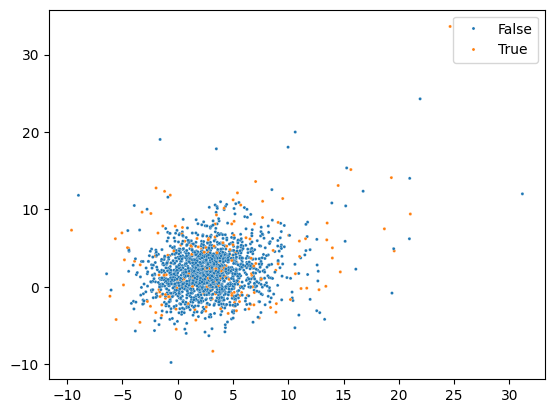

In [13]:
import seaborn as sns

LOI = 'HYP'

lead1 = encodings.view(n, channels, LATENT_DIM)[:,0,:]
lead1.shape
sns.scatterplot(x=lead1[:, 0].detach().cpu().numpy(), y=lead1[:, 1].detach().cpu().numpy(), hue=labels[LOI].detach().cpu().numpy(), s=5)
